In [2]:
import os
import sys
import pickle
import string

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering


from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

In [24]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = 2, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

def extract_clp_results(clustering_dict, Nframes, Nexp, rmax_list, act_list, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    LX = clustering_dict['LX']
    suffix = clustering_dict['suffix']
    Nwindows = len(rmax_list)
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, Nwindows, 3, len(act_list), Nexp])
    
    for i, (act, act_dir) in enumerate(zip(act_list, act_dir_list)):

        exp_list = []
        exp_dir_list = []

        for file in os.listdir(act_dir):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir, file))

        # sort the activity list and the activity directory list
        exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

        for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
            cl_res = np.load(os.path.join(exp_dir, 'cl_arr.npy'))[-Nframes:]
            cluster_arr[:,:cl_res.shape[1],:,i,j] = cl_res

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'arr{suffix}.npy'), cluster_arr)
    return cluster_arr


def extract_clp_results_single(clustering_dict, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    suffix = clustering_dict['suffix']
    Nframes = clustering_dict['Nframes']
  

    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, clustering_dict['Nwindows'], 3, clustering_dict['Nact'],])
    
    for i, act_dir in enumerate(act_dir_list):
        cl_res = np.load(os.path.join(act_dir, 'cl_arr.npy'))[-Nframes:]
        cluster_arr[:,:cl_res.shape[1],:,i] = cl_res


    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'arr{suffix}.npy'), cluster_arr)
    return cluster_arr

def get_defect_arr_from_frame(defect_dict, return_charge = False):
    """
    Convert dictionary of defects to array of defect positions
    Parameters:
    -----------
    defect_dict : dict
        Dictionary of defects positions and charges
    return_charge : bool
        If True, return defect charges as well

    Returns:
    --------
    defect_positions : np.ndarray
        Array of defect positions
    defect_charges : np.ndarray
    """

    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 3 if return_charge else 2])

    for i, defect in enumerate(defect_dict):
        defect_positions[i] = *defect['pos'], defect['charge'] if return_charge else defect['pos']
    return defect_positions

def get_clustering_signed(top_defect_list, method, rmax_list, method_kwargs, save = False, save_path = None):
    """
    
    Parameters:
    -----------
    Returns:
    --------
    """
  
    Nframes = len(top_defect_list)
    Nwindows = len(rmax_list)

    cl_arr = np.nan * np.ones([Nframes, Nwindows, 3])
   
    for frame, defects in enumerate(top_defect_list):
        # Get defect array for frame
        defect_arr = get_defect_arr_from_frame(defects, return_charge = True)
        defect_positions = defect_arr[:, :-1]
        defect_charges = defect_arr[:, -1] 

        if defect_positions is None:
            continue

        for i, rmax in enumerate(rmax_list):
            cst = method(distance_threshold = rmax, **method_kwargs)
            labels = cst.fit_predict(defect_positions)

            Ncl = np.max(labels) + 1
            Qc_arr = np.zeros(Ncl)

            for N in range(Ncl):
                mask = (labels == N)
                Qc = np.sum(defect_charges[mask])
                Qc_arr[N] = Qc
 
            all_neutral = float(np.all(Qc_arr == 0))
            Qcl = np.sum(np.abs(Qc_arr)) / Ncl
            cl_arr[frame, i] = [Ncl, Qcl, all_neutral]

    if save:
        # save labels list
        save_path = save_path if save_path is not None else 'labels_list.pkl'
        np.save(save_path, cl_arr)
    return cl_arr

def arg_func(arr, r_max_list, cutoff):
    if np.any(arr == cutoff):
        return r_max_list[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def arg_func_idx(arr, cutoff):
    if np.any(arr == cutoff):
        return np.argwhere(arr == cutoff)[0][0]
    else:
        return -1

def arg_func2(arr, cutoff):
    if np.any(arr == cutoff):
        return arr[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    

def get_defect_density(defect_list, area, return_charges=False, save_path = None,):
        """
        Get defect density for each frame in archive
        parameters:
            defect_list: list of lists of dictionaries holding defect charge and position for each frame 
            area: Area of system
            return_charges: if True, return list of densities of positive and negative defects
        returns:
            dens_defects: array of defect densities (Nframes, 3) if return_charges is True else (Nframes, 2)
        """

        if return_charges:
            # Initialize list of defect densities
            dens_pos_defects = []
            dens_neg_defects = []
            for defects in defect_list:
                # Get no. of defects
                nposdef = len([d for d in defects if d['charge'] == 0.5])
                nnegdef = len([d for d in defects if d['charge'] == -0.5])

                dens_pos_defects.append(nposdef / area)
                dens_neg_defects.append(nnegdef / area)

            if save_path is not None:
                np.savetxt(save_path + '_pos', dens_pos_defects)
                np.savetxt(save_path + '_neg', dens_neg_defects)
            return dens_pos_defects, dens_neg_defects
        else:
            dens_defects = []
            for defects in defect_list:
                # Get no. of defects
                ndef = len(defects)
                dens_defects.append(ndef / area)
            if save_path is not None:
                np.savetxt(save_path, dens_defects)
            return dens_defects


In [198]:
act_fwd

[0.14, 0.15, 0.16, 0.17, 0.18, 0.2, 0.22, 0.25, 0.3, 0.35]

In [197]:
act_dirs_fwd

['C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\dry\\na512\\fwd\\dry-ps-0.14-out',
 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\dry\\na512\\fwd\\dry-ps-0.15-out',
 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\dry\\na512\\fwd\\dry-ps-0.16-out',
 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\dry\\na512\\fwd\\dry-ps-0.17-out',
 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\dry\\na512\\fwd\\dry-ps-0.18-out',
 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\dry\\na512\\fwd\\dry-ps-0.20-out',
 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\dry\\na512\\fwd\\dry-ps-0.22-out',
 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\dry\\na512\\fwd\\dry-ps-0.25-out',
 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\

In [206]:
extract = True
save_figs = True

LX = 512
mode = 'dry'

defect_list = gen_analysis_dict(LX, mode)

fig_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Figures\\passive'
base_path_fwd = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\{mode}\\na{LX}\\fwd'
base_path_bck = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\{mode}\\na{LX}\\bck'
out_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{mode}\\na{LX}'

if not os.path.isdir(fig_path):
    os.makedirs(fig_path)
if not os.path.isdir(out_path):
    os.makedirs(out_path)


act_dirs_fwd = [os.path.join(base_path_fwd, x) for x in os.listdir(base_path_fwd)]
act_dirs_bck = [os.path.join(base_path_bck, x) for x in os.listdir(base_path_bck)] 

act_fwd = [float(x.split('-')[-2]) for x in os.listdir(base_path_fwd)]
act_bck = [float(x.split('-')[-2]) for x in os.listdir(base_path_bck)]

act_exclude_fwd = [0.006]
act_exclude_bck = []

Nact_fwd = len(act_fwd)
Nact_bck = len(act_bck)

rmax_list = np.arange(10, LX / 2)
Nframes = 51
Nwindows = len(rmax_list)
ninfo = 1000

cluster_dict_fwd = dict(LX = LX, Nframes = Nframes, Nact = len(act_fwd), Nwindows = len(rmax_list), path = out_path, suffix = '_fwd')
cluster_dict_bck = dict(LX = LX, Nframes = Nframes, Nact = len(act_bck), Nwindows = len(rmax_list), path = out_path, suffix = '_bck')

if extract:
    clp_arr_fwd = extract_clp_results_single(cluster_dict_fwd, act_dirs_fwd, save_path=out_path)
    clp_arr_bck = extract_clp_results_single(cluster_dict_bck, act_dirs_bck, save_path=out_path)

    def_arr_fwd = np.zeros([Nframes, Nact_fwd])
    def_arr_bck = np.zeros([Nframes, Nact_bck])

    for i, (act_dir_list, arr) in enumerate(zip([act_dirs_fwd, act_dirs_bck], [def_arr_fwd, def_arr_bck])):
        
        for j, act_dir in enumerate(act_dir_list):
            path = os.path.join(act_dir, 'defect_positions.pkl')
            with open(path, 'rb') as f:
                defect_dict = pickle.load(f)
            def_list_pos = get_defect_density(defect_dict, area = 1)
            arr[:, j] = def_list_pos

    # save 
    np.save(os.path.join(out_path, 'def_arr_fwd.npy'), def_arr_fwd)
    np.save(os.path.join(out_path, 'def_arr_bck.npy'), def_arr_bck)

else:
    clp_arr_fwd = np.load(os.path.join(out_path, 'arr_fwd.npy'))
    clp_arr_bck = np.load(os.path.join(out_path, 'arr_bck.npy'))

    def_arr_fwd = np.load(os.path.join(out_path, 'def_arr_fwd.npy'))
    def_arr_bck = np.load(os.path.join(out_path, 'def_arr_bck.npy'))

    conv_list_bck = np.load(os.path.join(out_path, 'conv_list_bck.npy'))
    conv_list_fwd = np.load(os.path.join(out_path, 'conv_list_fwd.npy'))



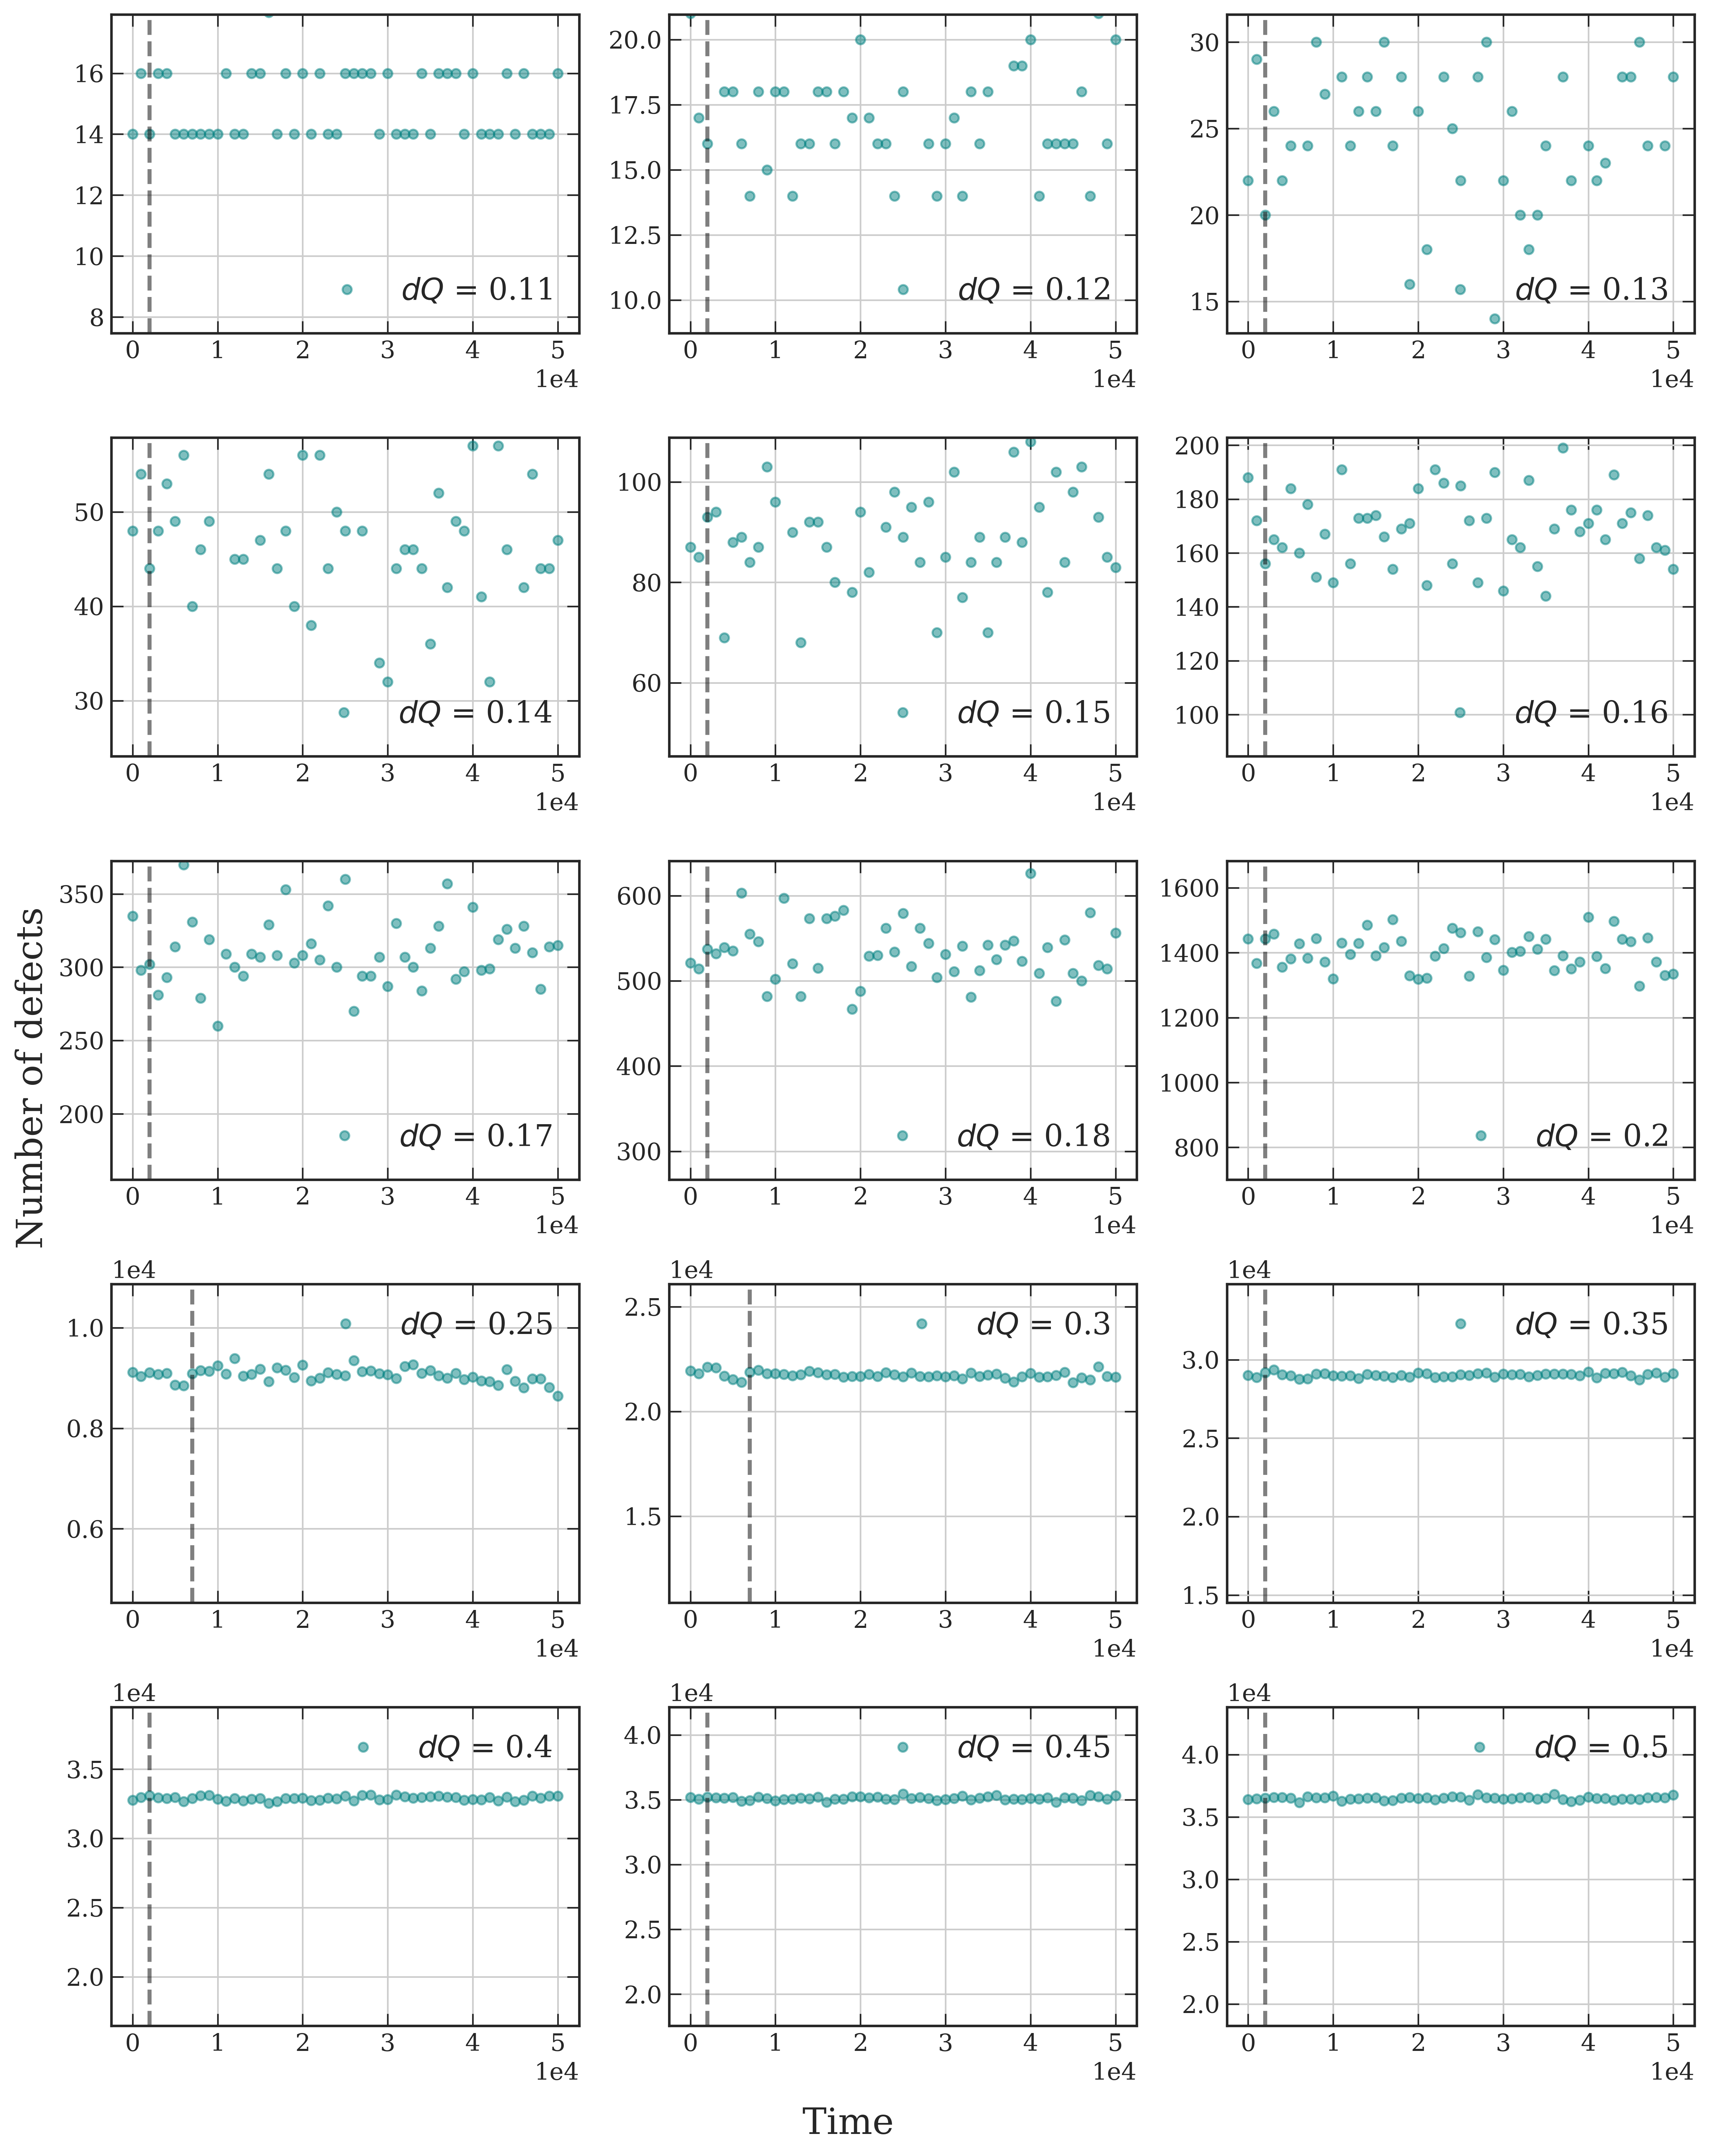

In [184]:
plot_density = False

ncols=3
nrows = np.ceil(len(act_bck) / ncols).astype(int)
fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(12, 3*nrows))
ax = ax.flatten()
conv_list_bck = np.zeros(Nact_bck)

for i, act in enumerate(act_bck):

        normalizer = LX ** 2 if plot_density else 1
        vals = def_arr_bck[:, i] / normalizer

        av = np.mean(vals)
    
        block_len = 5
        stationarity_dict = dict(interval_len = block_len, Njump = block_len, Nconverged = -14, max_sigma_dist = 1)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            x = est_stationarity(vals, **stationarity_dict)[0]
      #  x = est_stationarity(vals, **stationarity_dict)[0]
        conv_list_bck[i] = x
        ax[i].plot(np.arange(0, Nframes * ninfo, ninfo), vals, '.',
                    alpha = .5, markersize=9, label = rf'$dQ$ = {act}')
    
        if x > 0:
            ax[i].axvline(x * ninfo, color='black', linestyle='--', alpha=0.5)
        ax[i].set_ylim([0.5 * av, 1.2 * av])
        ax[i].legend()  
        ax[i].grid(True)

fig.supxlabel('Time')
fig.supylabel('Number of defects')

if save_figs:
    fig.savefig(os.path.join(fig_path, f'num_defects_{mode}_bck{LX}.png'))

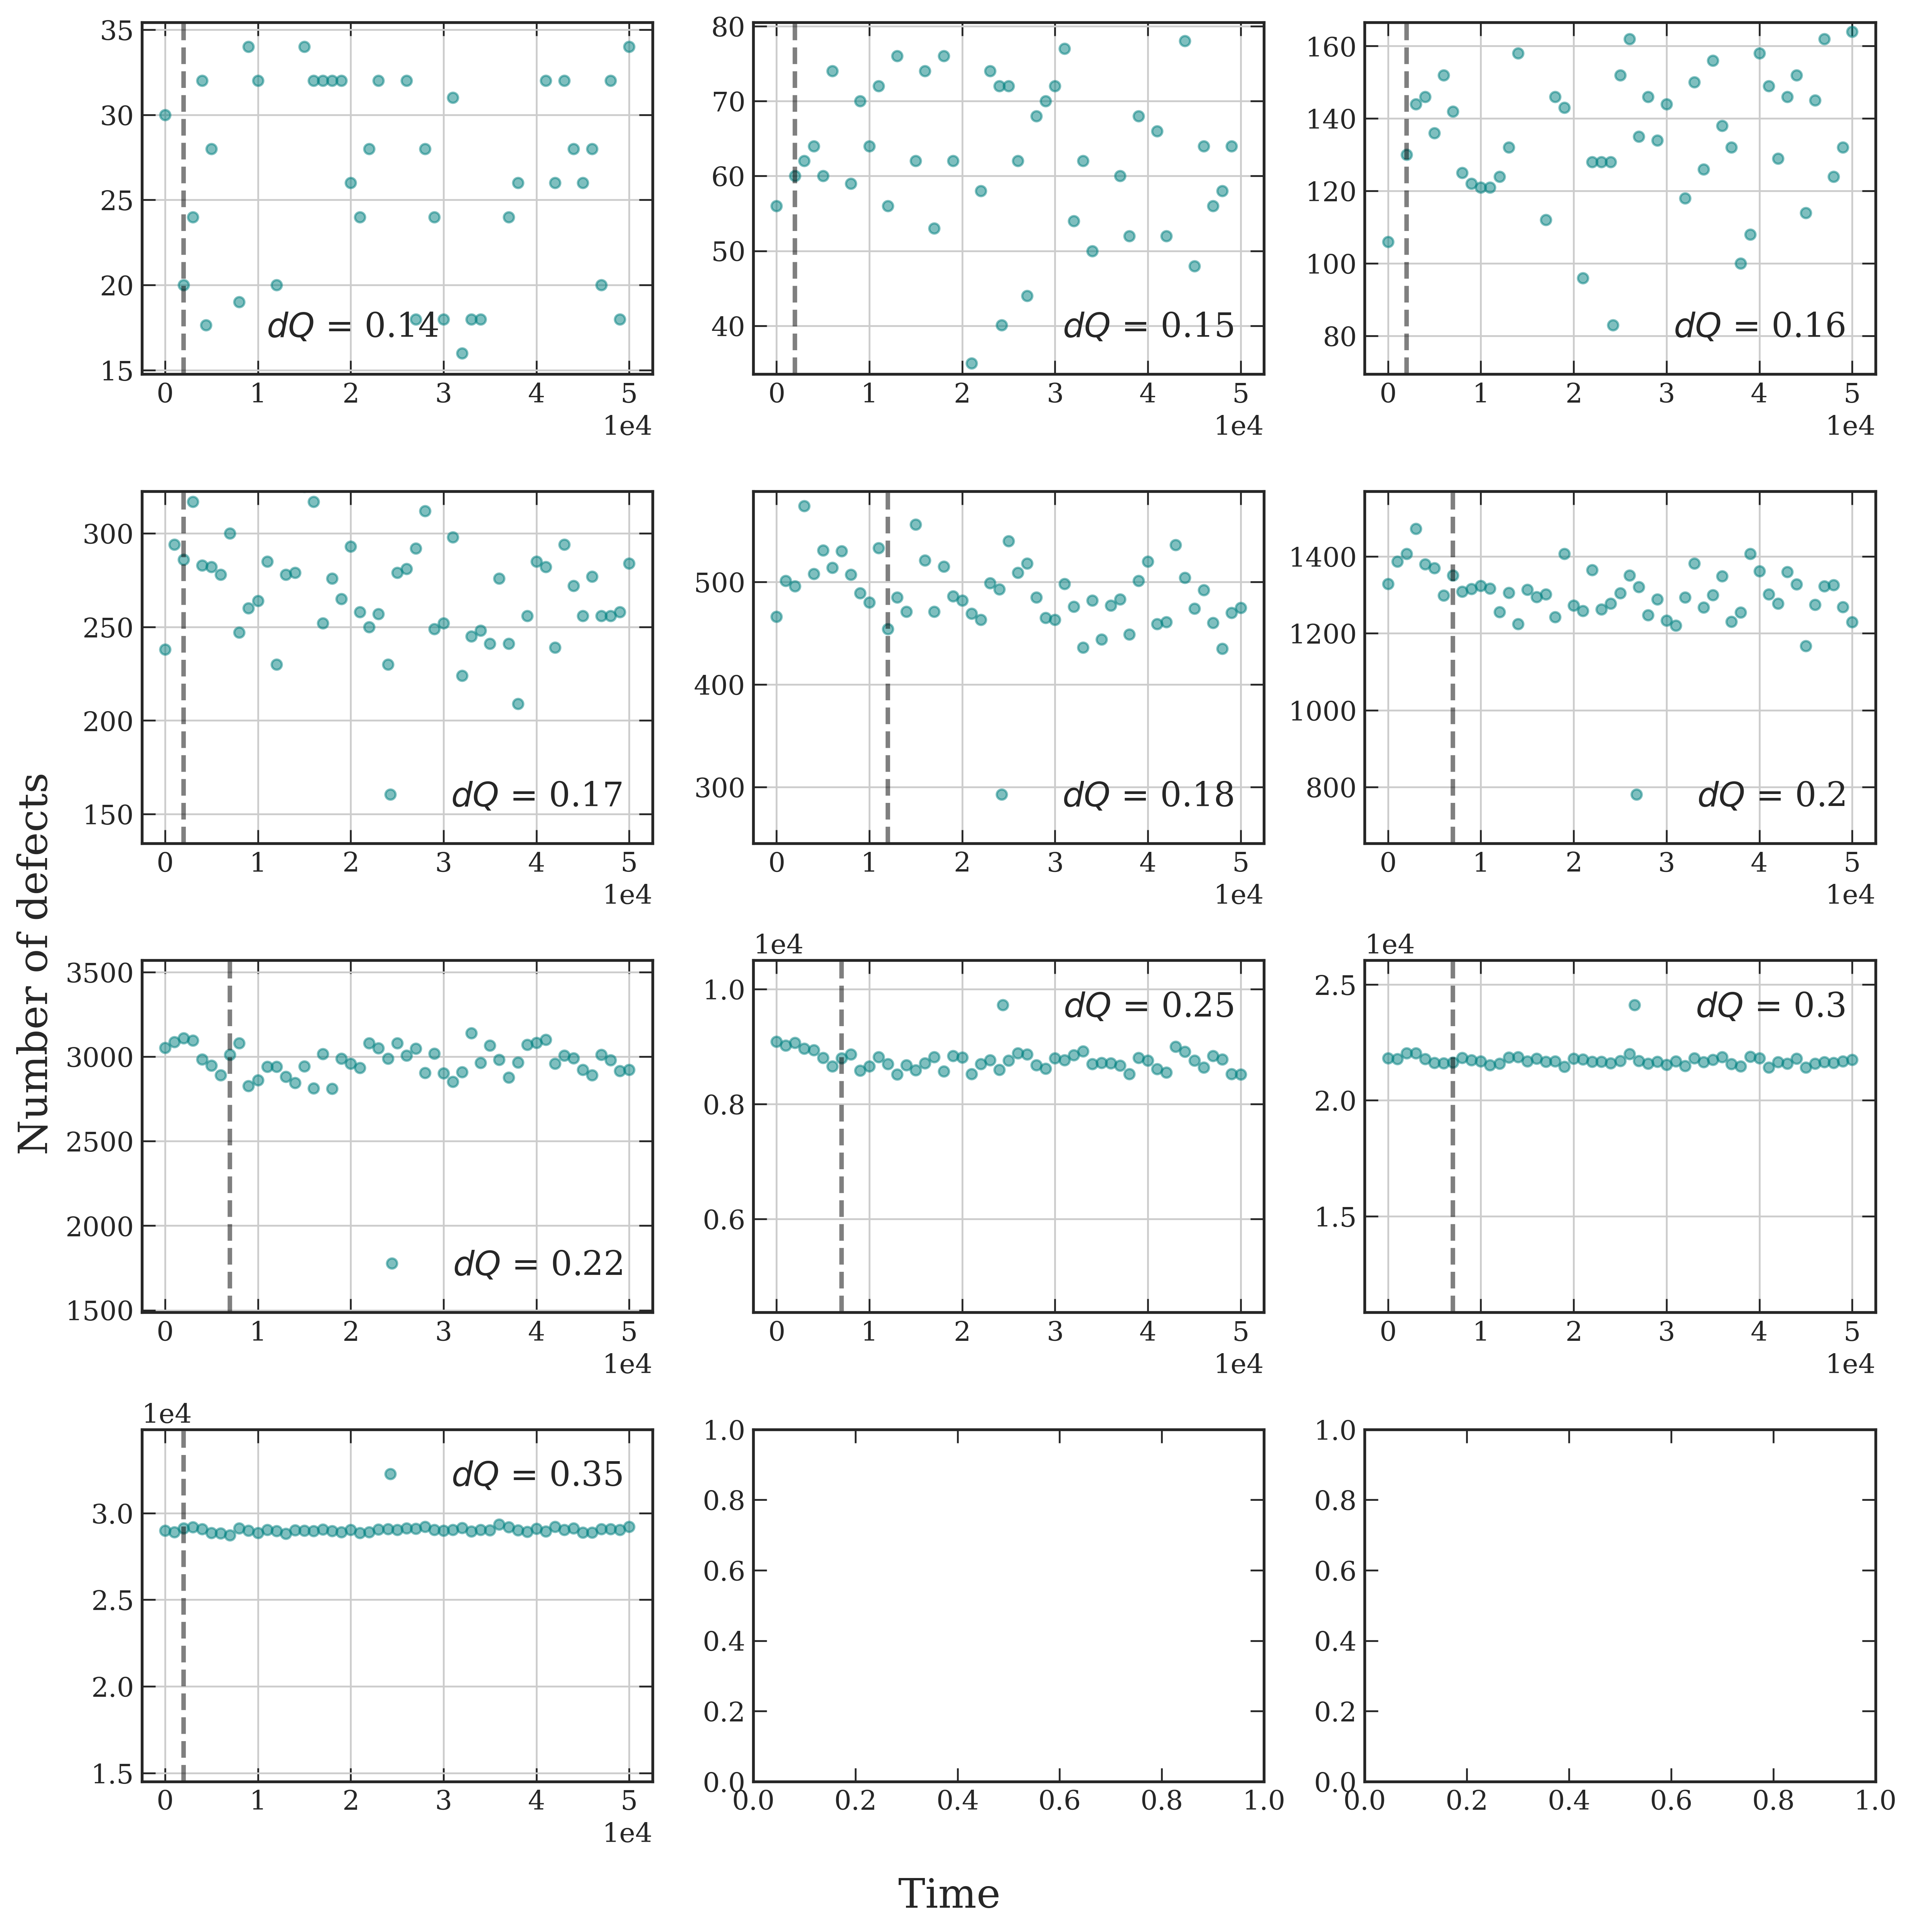

In [185]:
plot_density = False

ncols=3
nrows = np.ceil(len(act_fwd) / ncols).astype(int)
fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(12, 3*nrows))
ax = ax.flatten()
conv_list_fwd = np.zeros(Nact_fwd)

for i, act in enumerate(act_fwd):

    vals = def_arr_fwd[:, i] / (LX ** 2) if plot_density else def_arr_fwd[:, i]
    av = np.mean(vals)

    block_len = 5
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        stationarity_dict = dict(interval_len = block_len, Njump = block_len, Nconverged = -15, max_sigma_dist = 1)
        x = est_stationarity(vals, **stationarity_dict)[0]
    conv_list_fwd[i] = x
    ax[i].plot(np.arange(0, Nframes * ninfo, ninfo), vals, '.',
                alpha = .5, markersize=9, label = rf'$dQ$ = {act}')

    if x > 0:
        ax[i].axvline(x * ninfo, color='black', linestyle='--', alpha=0.5)
    ax[i].set_ylim([0.5 * av, 1.2 * av])
 #  ax[i].set_xlabel('Time')
    ax[i].legend()  
    ax[i].grid(True)    

fig.supxlabel('Time')
fig.supylabel('Number of defects')

# save conv list
#np.save(os.path.join(out_path, 'conv_list.npy'), conv_list)
if save_figs:
    fig.savefig(os.path.join(fig_path, f'num_defects_{mode}_fwd{LX}.png'))

In [186]:
def arg_func(arr, r_max_list, cutoff):
    if np.any(arr == cutoff):
        return r_max_list[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def arg_func_idx(arr, cutoff):
    if np.any(arr == cutoff):
        return np.argwhere(arr == cutoff)[0][0]
    else:
        return -1

def arg_func2(arr, cutoff):
    if np.any(arr == cutoff):
        return arr[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1

In [91]:
lmax_arr_fwd.shape, idx_arr_fwd.shape, clp_arr_bck.shape

((51, 8), (51, 8), (51, 246, 3, 13))

In [187]:
uncertainty_multiplier = 5
ncutoff_frac_lower = .05

arg_func1d = lambda arr: arg_func(arr, rmax_list, cutoff = 1)

lmax_arr_fwd = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_fwd[:, :, -1, :,])
lmax_arr_bck = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_bck[:, :, -1, :,])

lperc_arr_fwd = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_fwd[:, :, 0, :,])
lperc_arr_bck = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr_bck[:, :, 0, :,])

idx_arr_fwd = np.apply_along_axis(lambda arr: arg_func_idx(arr, cutoff = 1), axis=1, arr=clp_arr_fwd[:, :, 0, :,])
idx_arr_bck = np.apply_along_axis(lambda arr: arg_func_idx(arr, cutoff = 1), axis=1, arr=clp_arr_bck[:, :, 0, :,])

qmax_arr_fwd = np.nan * np.zeros_like(idx_arr_fwd)
qmax_arr_bck = np.nan * np.zeros_like(idx_arr_bck)

lmax_av_fwd = np.nan * np.zeros((len(act_fwd), 2))
lmax_av_bck = np.nan * np.zeros((len(act_bck), 2))
lperc_av_fwd = np.nan * np.zeros((len(act_fwd), 2))
lperc_av_bck = np.nan * np.zeros((len(act_bck), 2))


for i, _ in enumerate(act_fwd):
    ff_idx = int(conv_list_fwd[i])

    mask = (lmax_arr_fwd[ff_idx:, i,] > 0)
    nsamples = mask.sum()
    if nsamples / lmax_arr_fwd[ff_idx:, i,].size > ncutoff_frac_lower:
        arr_res = lmax_arr_fwd[ff_idx:, i,][mask]
        lmax_av_fwd[i,0] = np.nanmean(arr_res)
        lmax_av_fwd[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)


    mask_perc = (lperc_arr_fwd[ff_idx:, i,] > 0)
    nsamples_perc = mask_perc.sum()
    if nsamples_perc / lperc_arr_fwd[ff_idx:, i,].size > ncutoff_frac_lower:
        arr_res_perc = lperc_arr_fwd[ff_idx:, i,][mask_perc]
        lperc_av_fwd[i,0] = np.nanmean(arr_res_perc)
        lperc_av_fwd[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    for f in range(ff_idx, Nframes):
            
            arr_idx = idx_arr_fwd[f, i]
            qmax_arr_fwd[f, i] = clp_arr_fwd[f, arr_idx, 1, i,]  #np.diag(clp_arr_fwd[f, arr_idx, 1, i,])

for i, _ in enumerate(act_bck):
    ff_idx = int(conv_list_bck[i])

    mask = (lmax_arr_bck[ff_idx:, i,] > 0)
    nsamples = mask.sum()
    if nsamples / lmax_arr_bck[ff_idx:, i,].size > ncutoff_frac_lower:
        arr_res = lmax_arr_bck[ff_idx:, i,][mask]
        lmax_av_bck[i,0] = np.nanmean(arr_res)
        lmax_av_bck[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)

    mask_perc = (lperc_arr_bck[ff_idx:, i,] > 0)
    nsamples_perc = mask_perc.sum()
    if nsamples_perc / lperc_arr_bck[ff_idx:, i,].size > ncutoff_frac_lower:
        arr_res_perc = lperc_arr_bck[ff_idx:, i,][mask_perc]
        lperc_av_bck[i,0] = np.nanmean(arr_res_perc)
        lperc_av_bck[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    for f in range(ff_idx, Nframes):
            
            arr_idx = idx_arr_bck[f, i]
            qmax_arr_bck[f, i] = clp_arr_bck[f, arr_idx, 1, i,]  #np.diag(clp_arr_fwd[f, arr_idx, 1, i,])
     

## Total charge is not generally 0. This must be accounted for

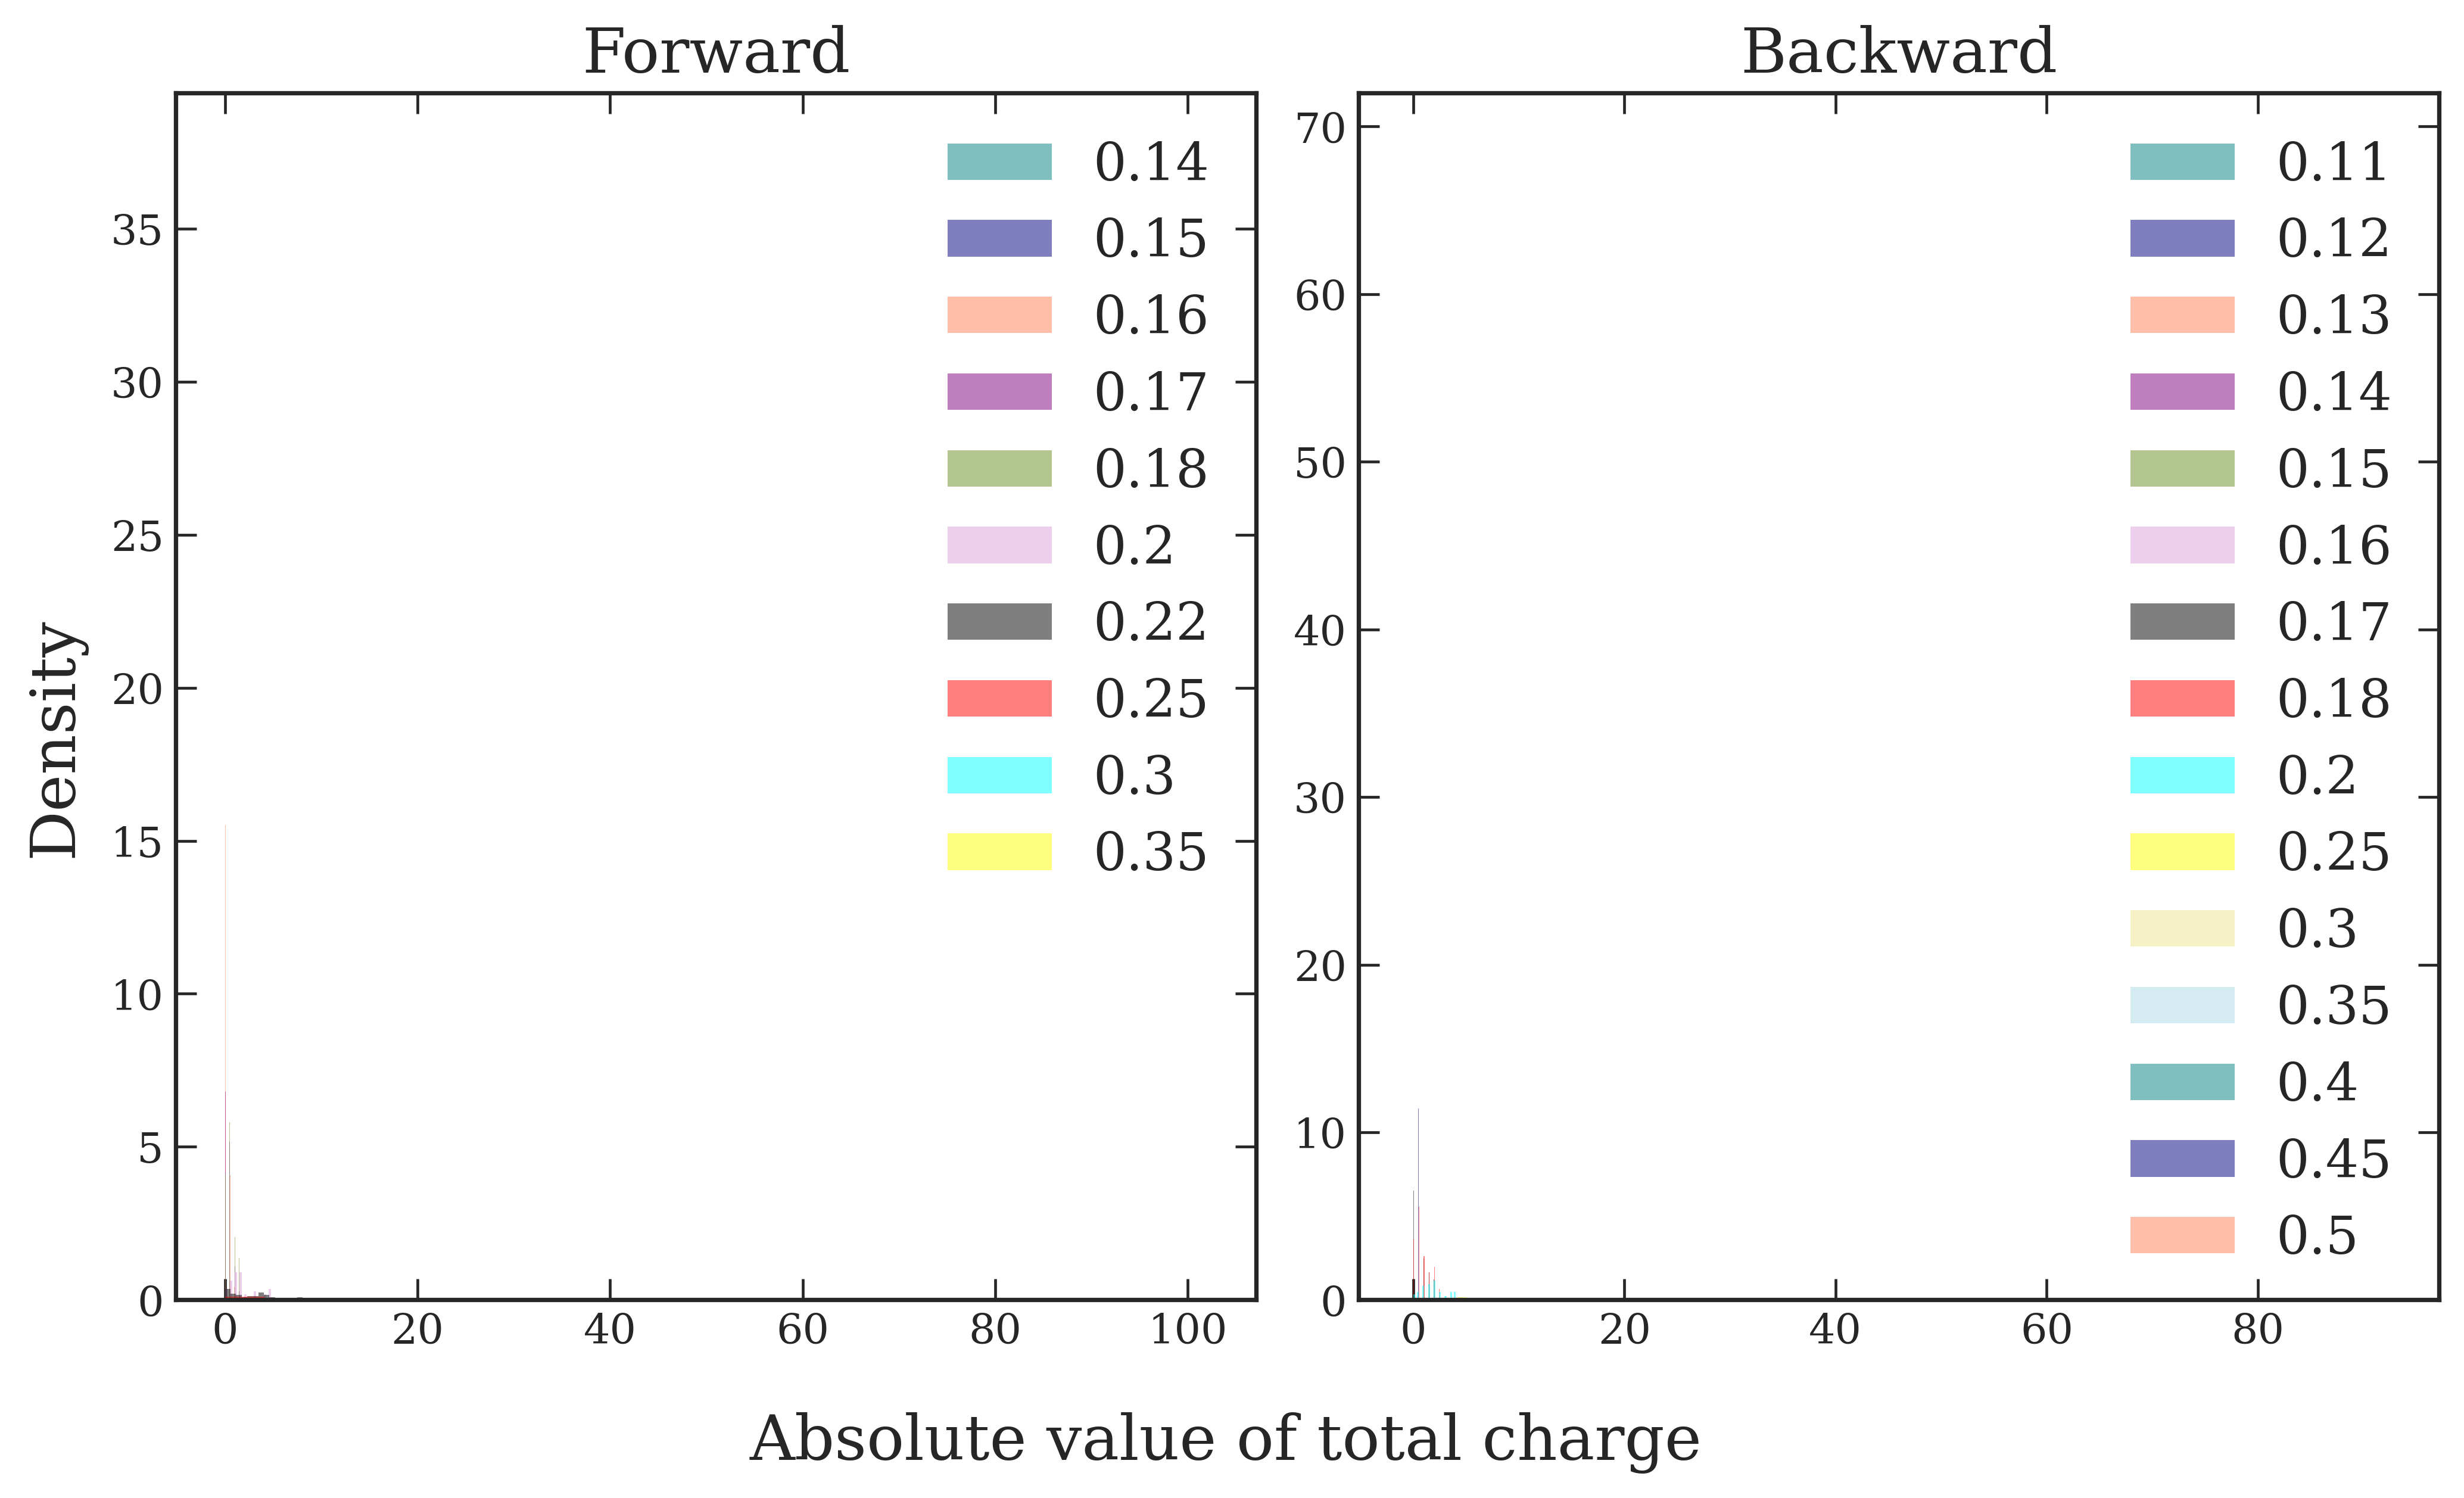

In [188]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax = ax.flatten()
for i, act in enumerate(act_fwd):
    ff_idx = int(conv_list_fwd[i])
    vals = qmax_arr_fwd[ff_idx:, i].flatten() #/ (av_def[i,0] )  
    ax[0].hist(vals[~np.isnan(vals)], bins = 20, alpha = .5, label = act, density=True)
    ax[0].title.set_text('Forward') 
for i, act in enumerate(act_bck):
    if act in []:
        continue
    ff_idx = int(conv_list_bck[i])
    vals = qmax_arr_bck[ff_idx:, i].flatten() #/ (av_def[i,0] )  
    ax[1].hist(vals[~np.isnan(vals)], bins = 40, alpha = .5, label = act, density=True)
    ax[1].title.set_text('Backward')
ax[0].legend()
ax[1].legend()
fig.supylabel('Density')
fig.supxlabel('Absolute value of total charge')

if save_figs:
    fig.savefig(os.path.join(fig_path, 'qmax_hist.png'), bbox_inches = 'tight', dpi = 420)

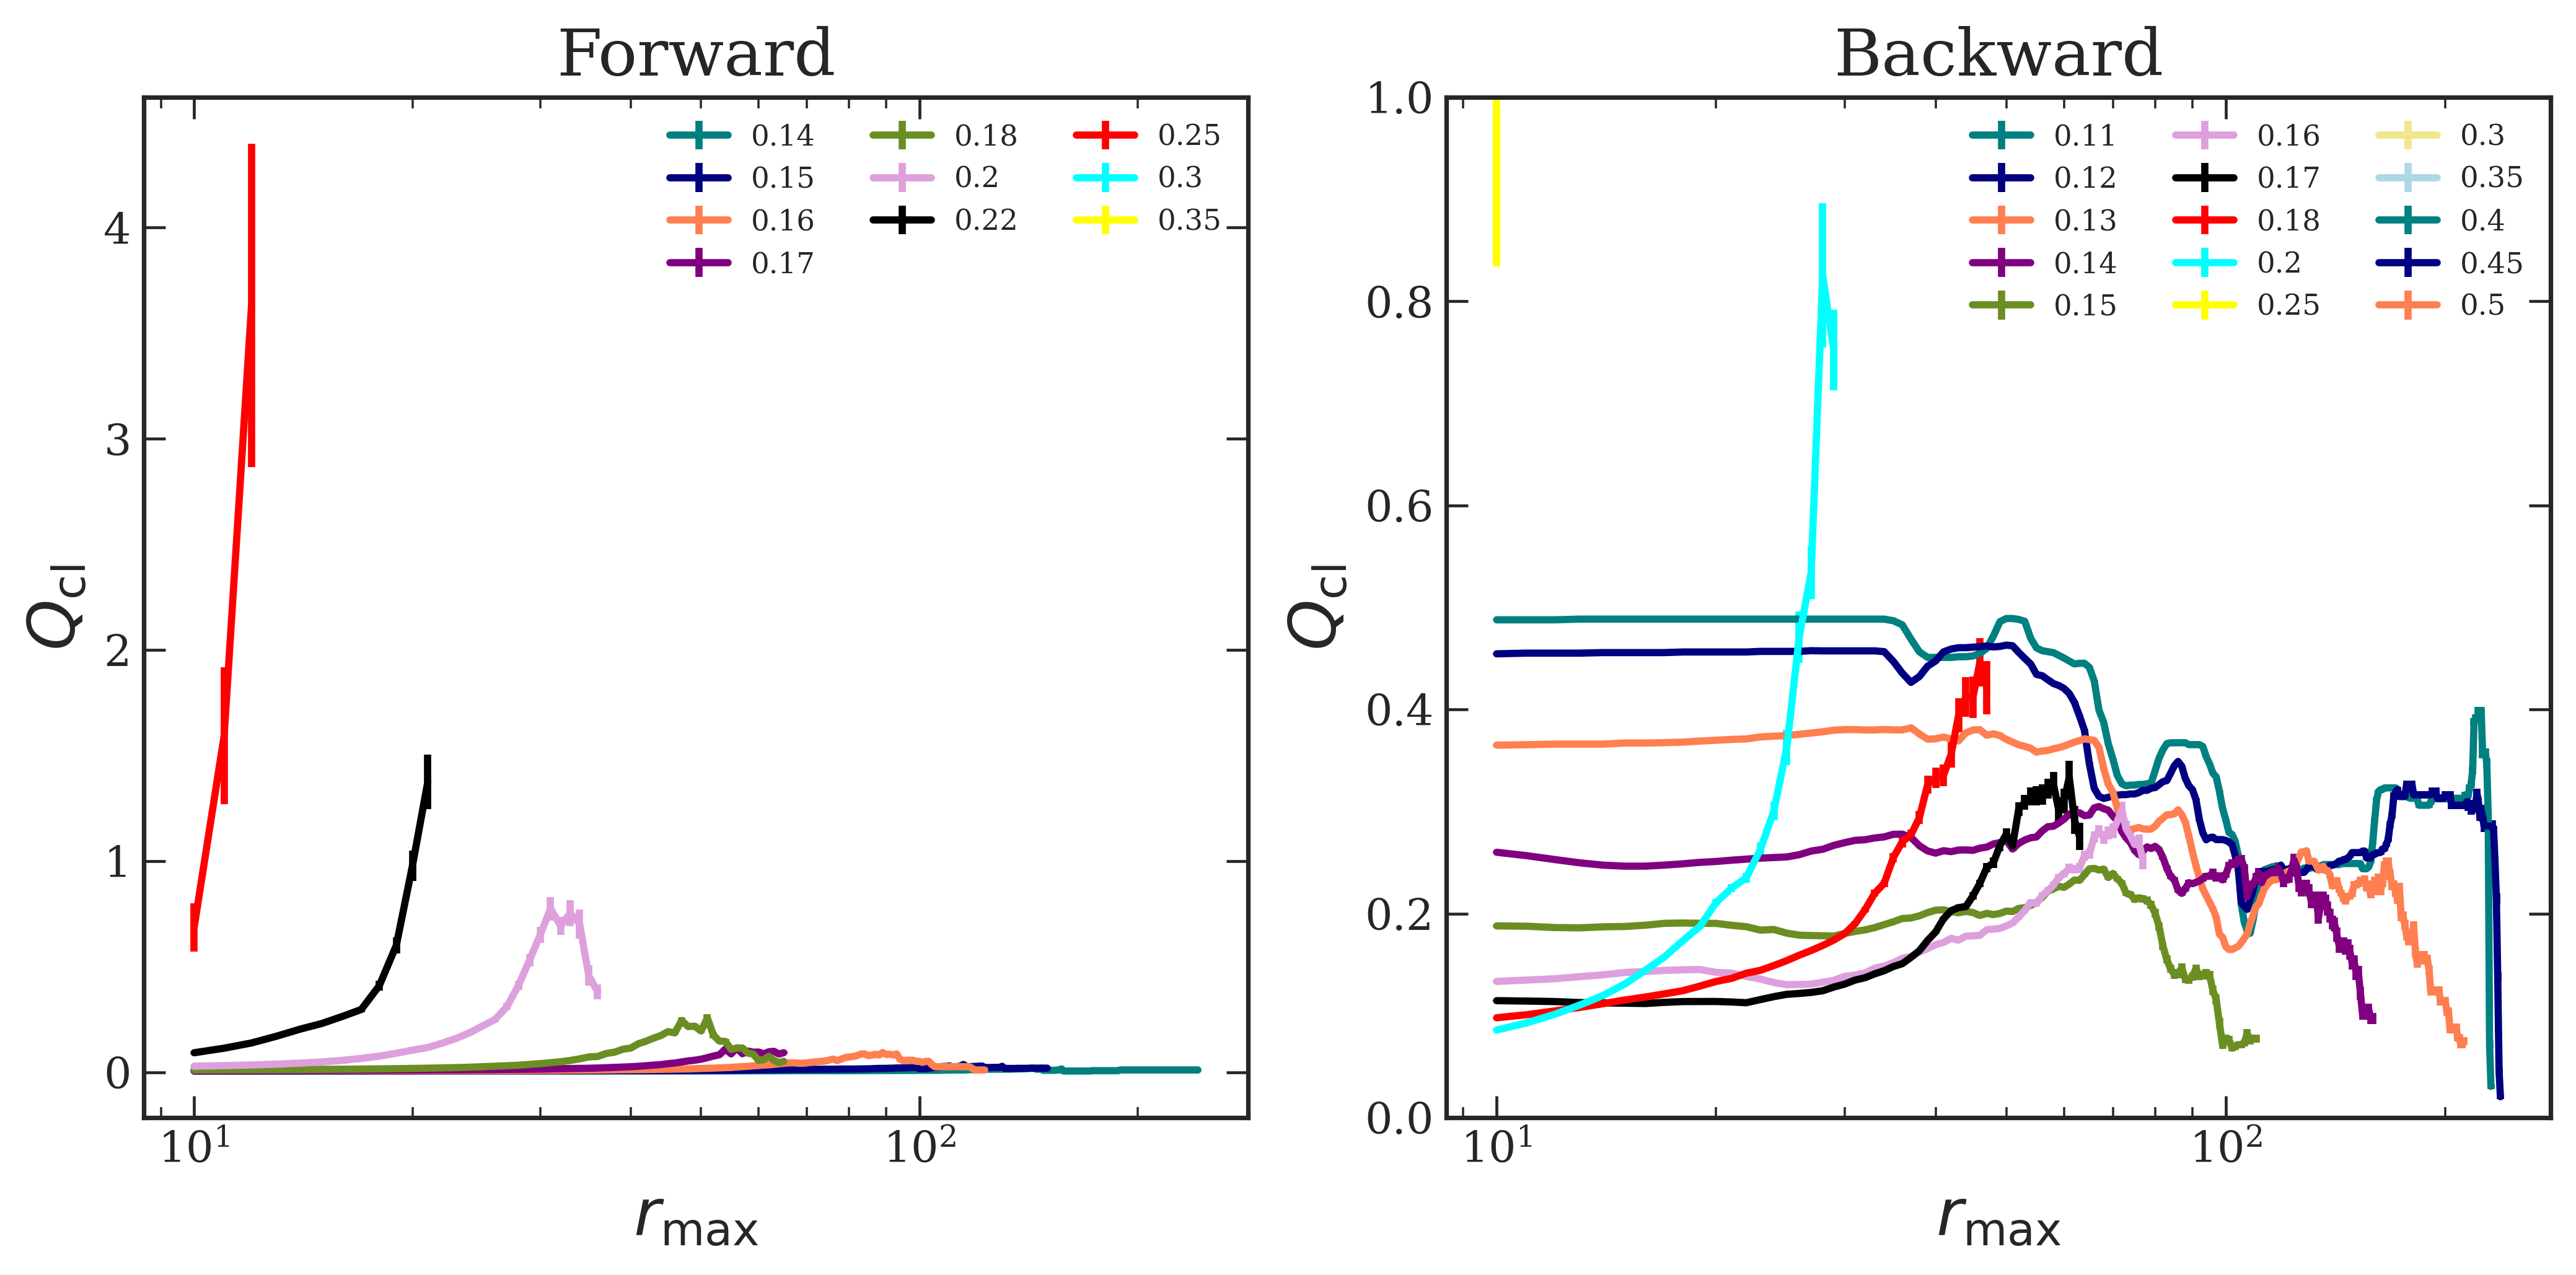

In [207]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))


for i, act in enumerate(act_fwd):
    if act in [.007,.011]:
        continue
    ff_idx = int(conv_list_fwd[i])
    vals = clp_arr_fwd[ff_idx:, :, 1, i,]
    max_idx = int(np.max(idx_arr_fwd[ff_idx, i,]))
    vals = np.nan_to_num(vals[:,:max_idx,],)
    qav = np.nanmean(vals, axis=(0,))
    qstd = np.nanstd(vals, axis=(0,)) \
    / np.sqrt((vals.size) / uncertainty_multiplier)

    ax[0].errorbar(rmax_list[:max_idx], qav, qstd, label=f'{act}')
    ax[0].title.set_text('Forward')

for i, act in enumerate(act_bck):
    if act in [0.007,.008]:
        continue
    ff_idx = int(conv_list_bck[i])
    vals = clp_arr_bck[ff_idx:, :, 1, i,]
    max_idx = int(np.max(idx_arr_bck[ff_idx, i]))
    vals = np.nan_to_num(vals[:,:max_idx,],)
    qav = np.nanmean(vals, axis=(0,))
    qstd = np.nanstd(vals, axis=(0,)) \
    / np.sqrt((vals.size) / uncertainty_multiplier)

    ax[1].errorbar(rmax_list[:max_idx], qav, qstd, label=f'{act}')
    ax[1].title.set_text('Backward')


for a in ax:
    a.set_xscale('log')
    a.set_xlabel(r'$r_{\max}$')
    a.set_ylabel(r'$Q_{\mathrm{cl}}$')
    a.legend(ncols=3, fontsize=8)

ax[1].set_ylim([0, 1.])    
fig.tight_layout()

if save_figs:
    fig.savefig(os.path.join(fig_path, 'dry_qcl.png'), bbox_inches = 'tight', dpi = 420)

In [190]:
qarr_shifted_fwd = np.nan * np.zeros((Nframes, len(rmax_list), len(act_fwd)))
qarr_shifted_bck = np.nan * np.zeros((Nframes, len(rmax_list), len(act_bck)))

q_av_fwd = np.nan * np.zeros((len(act_fwd), len(rmax_list), 2))
q_av_bck = np.nan * np.zeros((len(act_bck), len(rmax_list), 2))

for i, act in enumerate(act_fwd):
    qarr_shifted_fwd[:,:, i] = clp_arr_fwd[:, :, 1, i] - qmax_arr_fwd[:,i][:, None] / clp_arr_fwd[:, :, 0, i]
for i, act in enumerate(act_bck):
    qarr_shifted_bck[:,:, i] = clp_arr_bck[:, :, 1, i] - qmax_arr_bck[:,i][:, None] / clp_arr_bck[:, :, 0, i]

# replace nan values with 0
np.nan_to_num(qarr_shifted_fwd, copy = False)
np.nan_to_num(qarr_shifted_bck, copy = False)

for i, act in enumerate(act_fwd):
    ff_idx = int(conv_list_fwd[i])
    nsamples = qarr_shifted_fwd[ff_idx:, 0, i,].size
    q_av_fwd[i, :, 0] = np.nanmean(qarr_shifted_fwd[ff_idx:, :, i,], axis=(0,))
    q_av_fwd[i, :, 1] = np.nanstd(qarr_shifted_fwd[ff_idx:, :, i,], axis=(0,)) \
    / np.sqrt(nsamples / uncertainty_multiplier)

for i, act in enumerate(act_bck):
    ff_idx = int(conv_list_bck[i])
    nsamples = qarr_shifted_bck[ff_idx:, 0, i,].size
    q_av_bck[i, :, 0] = np.nanmean(qarr_shifted_bck[ff_idx:, :, i,], axis=(0,))
    q_av_bck[i, :, 1] = np.nanstd(qarr_shifted_bck[ff_idx:, :, i,], axis=(0,)) \
    / np.sqrt(nsamples / uncertainty_multiplier)


In [192]:
qpeak_fwd = np.nan * np.zeros((len(act_fwd), 2))
qpeak_bck = np.nan * np.zeros((len(act_bck), 2))
lneutral_fwd = np.nan * np.zeros((len(act_fwd), 2))
lneutral_bck = np.nan * np.zeros((len(act_bck), 2))

for i, act in enumerate(act_fwd):
    idx_max = np.argmax(q_av_fwd[i, :, 0])

    arg_neutral_lower = np.argwhere(q_av_fwd[i, :, 0]-q_av_fwd[i, :, 1] <= 0)
    if len(arg_neutral_lower) == 0:
        idx_neutral_lower = np.argwhere(q_av_fwd[i, :, 0]-2*q_av_fwd[i, :, 1] <= 0)[0][0]
        idx_neutral = idx_neutral_lower
        print(i,act)
    else:
        idx_neutral_lower = arg_neutral_lower[0][0]
        try:
            idx_neutral_upper = np.argwhere(q_av_fwd[i, :, 0]+q_av_fwd[i, :, 1] <= 0)[0][0]
            idx_neutral = np.median([idx_neutral_lower, idx_neutral_upper])
        except:
            idx_neutral = idx_neutral_lower

    qpeak_fwd[i] = q_av_fwd[i, idx_max]
    if idx_neutral % 1 != 0.:
        lneutral_fwd[i,0] = (rmax_list[idx_neutral_upper] + rmax_list[idx_neutral_lower]) / 2
    else:
        lneutral_fwd[i,0] = rmax_list[int(idx_neutral)] 
    lneutral_fwd[i,1] = max((rmax_list[idx_neutral_upper] - rmax_list[idx_neutral_lower]) / 2, np.diff(rmax_list)[0] / 2)

for i, act in enumerate(act_bck):
    idx_max = np.argmax(q_av_bck[i, :, 0])
    idx_neutral_lower = np.argwhere(q_av_bck[i, :, 0]-q_av_bck[i, :, 1] <= 0)[0][0]
    idx_neutral_upper = np.argwhere(q_av_bck[i, :, 0]+q_av_bck[i, :, 1] <= 0)[0][0]
    idx_neutral = np.median([idx_neutral_lower, idx_neutral_upper])

    qpeak_bck[i] = q_av_bck[i, idx_max]
    if idx_neutral % 1 != 0.:
        lneutral_bck[i,0] = (rmax_list[idx_neutral_upper] + rmax_list[idx_neutral_lower]) / 2
    else:
        lneutral_bck[i,0] = rmax_list[int(idx_neutral)]
    lneutral_bck[i,1] = max((rmax_list[idx_neutral_upper] - rmax_list[idx_neutral_lower]) / 2, np.diff(rmax_list)[0] / 2)




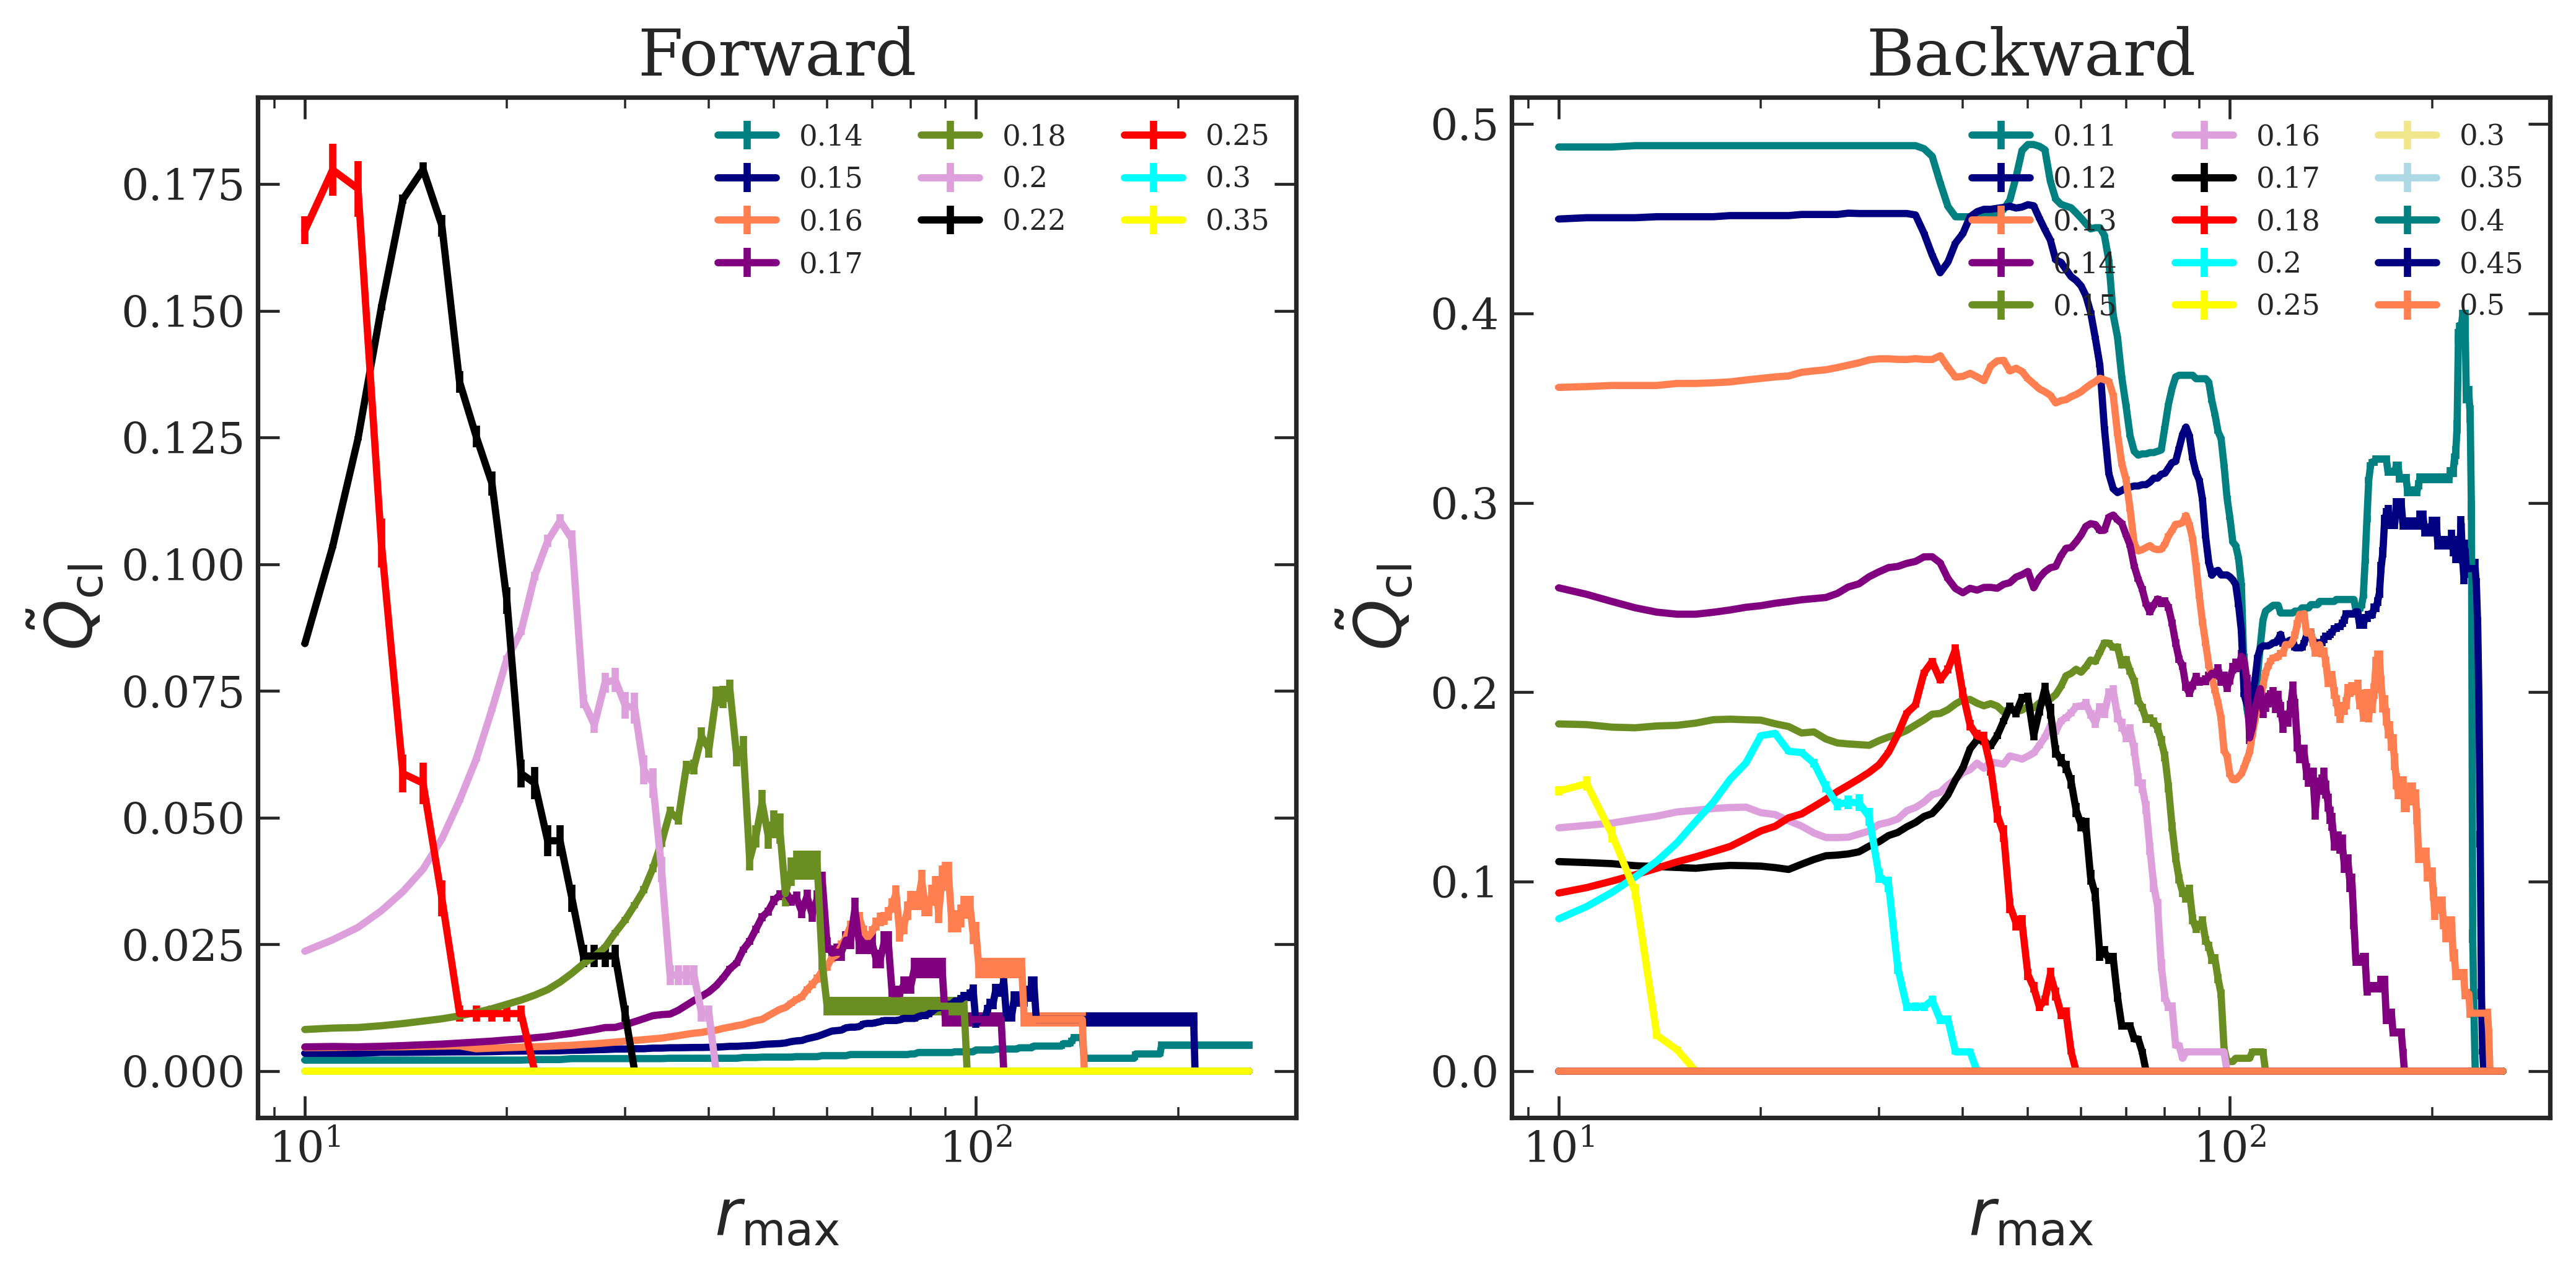

In [194]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))


for i, act in enumerate(act_fwd):
    if act in act_exclude_fwd:
        continue
    if act in [.011, .009]:
        continue

    ff_idx = int(conv_list_fwd[i])
    vals = qarr_shifted_fwd[ff_idx:, :, i,]

    qav = np.nanmean(vals, axis=(0,))
    qstd = np.nanstd(vals, axis=(0,)) \
    / np.sqrt((vals.size) / uncertainty_multiplier)

    ax[0].errorbar(rmax_list[:], qav, qstd, label=f'{act}')
    ax[0].title.set_text('Forward')

for i, act in enumerate(act_bck):
    if act in act_exclude_bck:
        continue
    if act in [.001, .01, .012, .003, .009]:
        continue

    ff_idx = int(conv_list_bck[i])
    vals = qarr_shifted_bck[ff_idx:, :, i,]

    qav = np.nanmean(vals, axis=(0,))
    qstd = np.nanstd(vals, axis=(0,)) \
    / np.sqrt((vals.size) / uncertainty_multiplier)

    ax[1].errorbar(rmax_list[:], qav, qstd, label=f'{act}')
    ax[1].title.set_text('Backward')

for a in ax:
    a.set_xscale('log')
    a.set_xlabel(r'$r_{\max}$')
    a.set_ylabel(r'$\tilde{Q}_{\mathrm{cl}}$')
    a.legend(ncols=3, fontsize=8)

fig.tight_layout()
if save_figs:
    fig.savefig(os.path.join(fig_path, 'dry_qcl_shift.png'), bbox_inches = 'tight', dpi = 420)

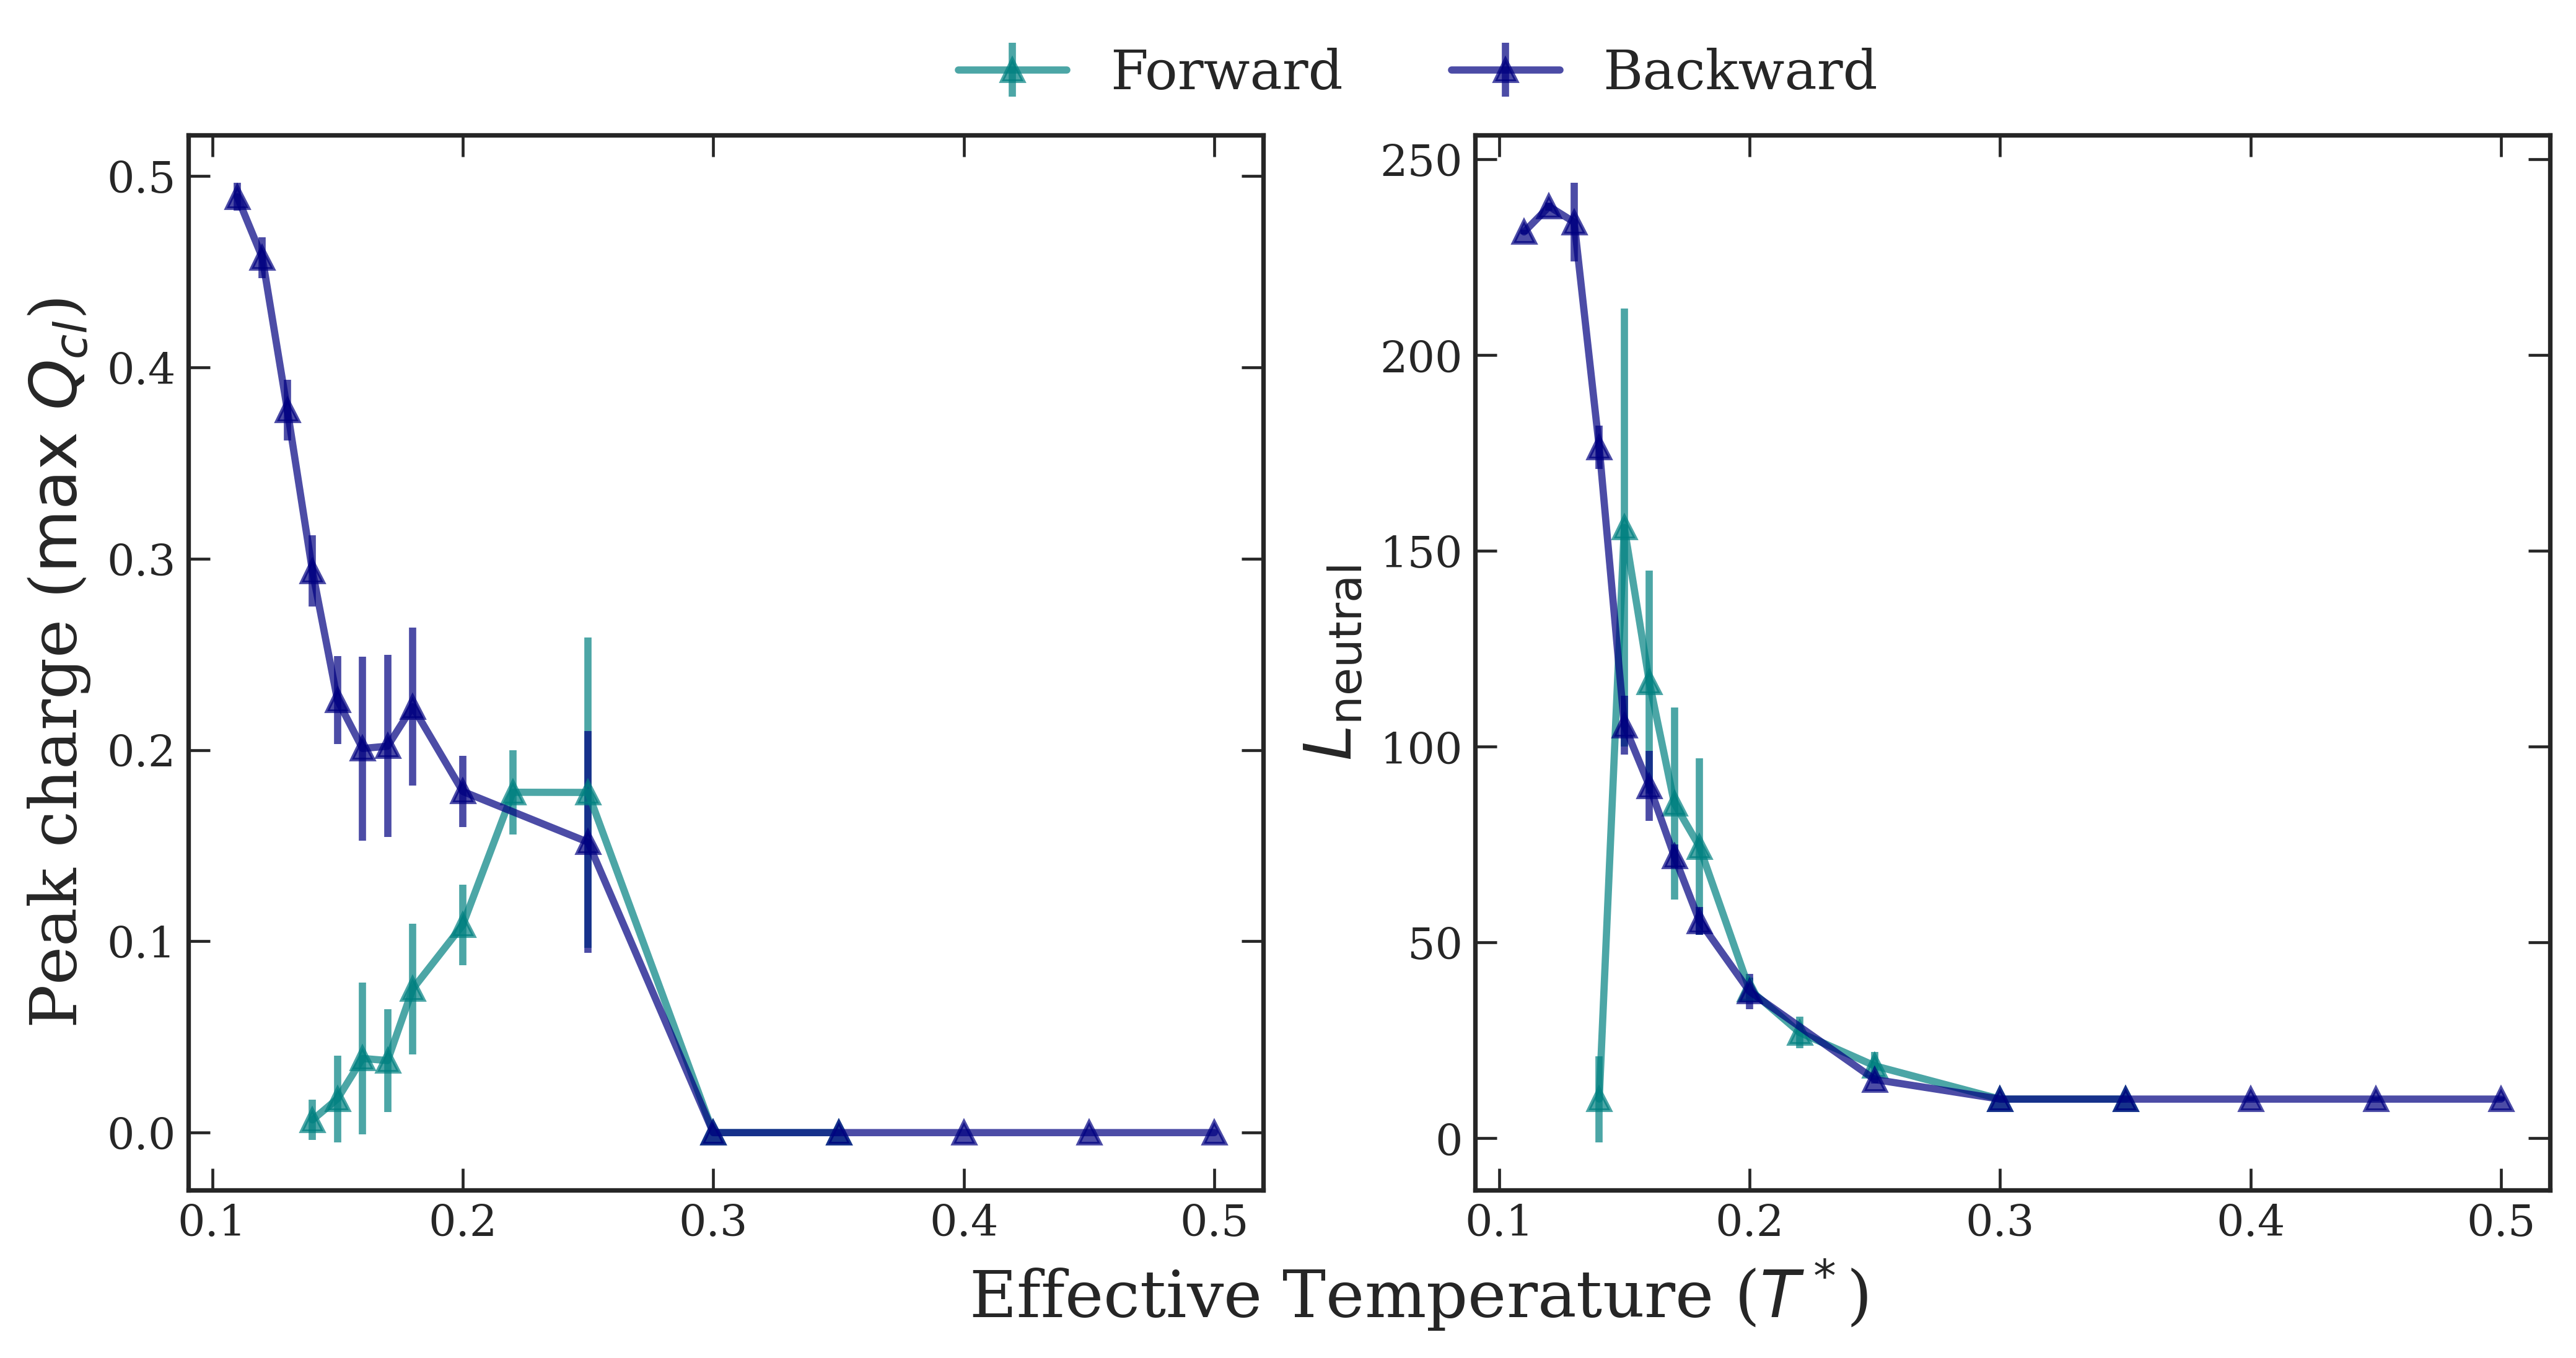

In [196]:
fig, ax = plt.subplots(ncols=2, figsize = (10, 5))

ax[0].errorbar(act_fwd, qpeak_fwd[:, 0], yerr = qpeak_fwd[:, 1],  fmt = '^-', alpha=.7, label = 'Forward')
ax[0].errorbar(act_bck, qpeak_bck[:, 0], yerr = qpeak_bck[:, 1], fmt = '^-', alpha=.7, label = 'Backward')
ax[0].set_ylabel(r'Peak charge ($\mathrm{max} ~Q_{cl}$)')


ax[1].errorbar(act_fwd, lneutral_fwd[:, 0], yerr = lneutral_fwd[:, 1], fmt = '^-', alpha=.7)
ax[1].errorbar(act_bck, lneutral_bck[:, 0], yerr = lneutral_bck[:, 1], fmt = '^-', alpha=.7)
ax[1].set_ylabel(r'$L_{\mathrm{neutral}}$')


fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)
fig.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.55, 1.075))      
fig.tight_layout()

if save_figs:
    fig.savefig(os.path.join(fig_path, 'qpeak_lneutral.png'), bbox_inches = 'tight', dpi = 420)

In [203]:
act_bck, act_fwd

([0.11,
  0.12,
  0.13,
  0.14,
  0.15,
  0.16,
  0.17,
  0.18,
  0.2,
  0.25,
  0.3,
  0.35,
  0.4,
  0.45,
  0.5],
 [0.14, 0.15, 0.16, 0.17, 0.18, 0.2, 0.22, 0.25, 0.3, 0.35])

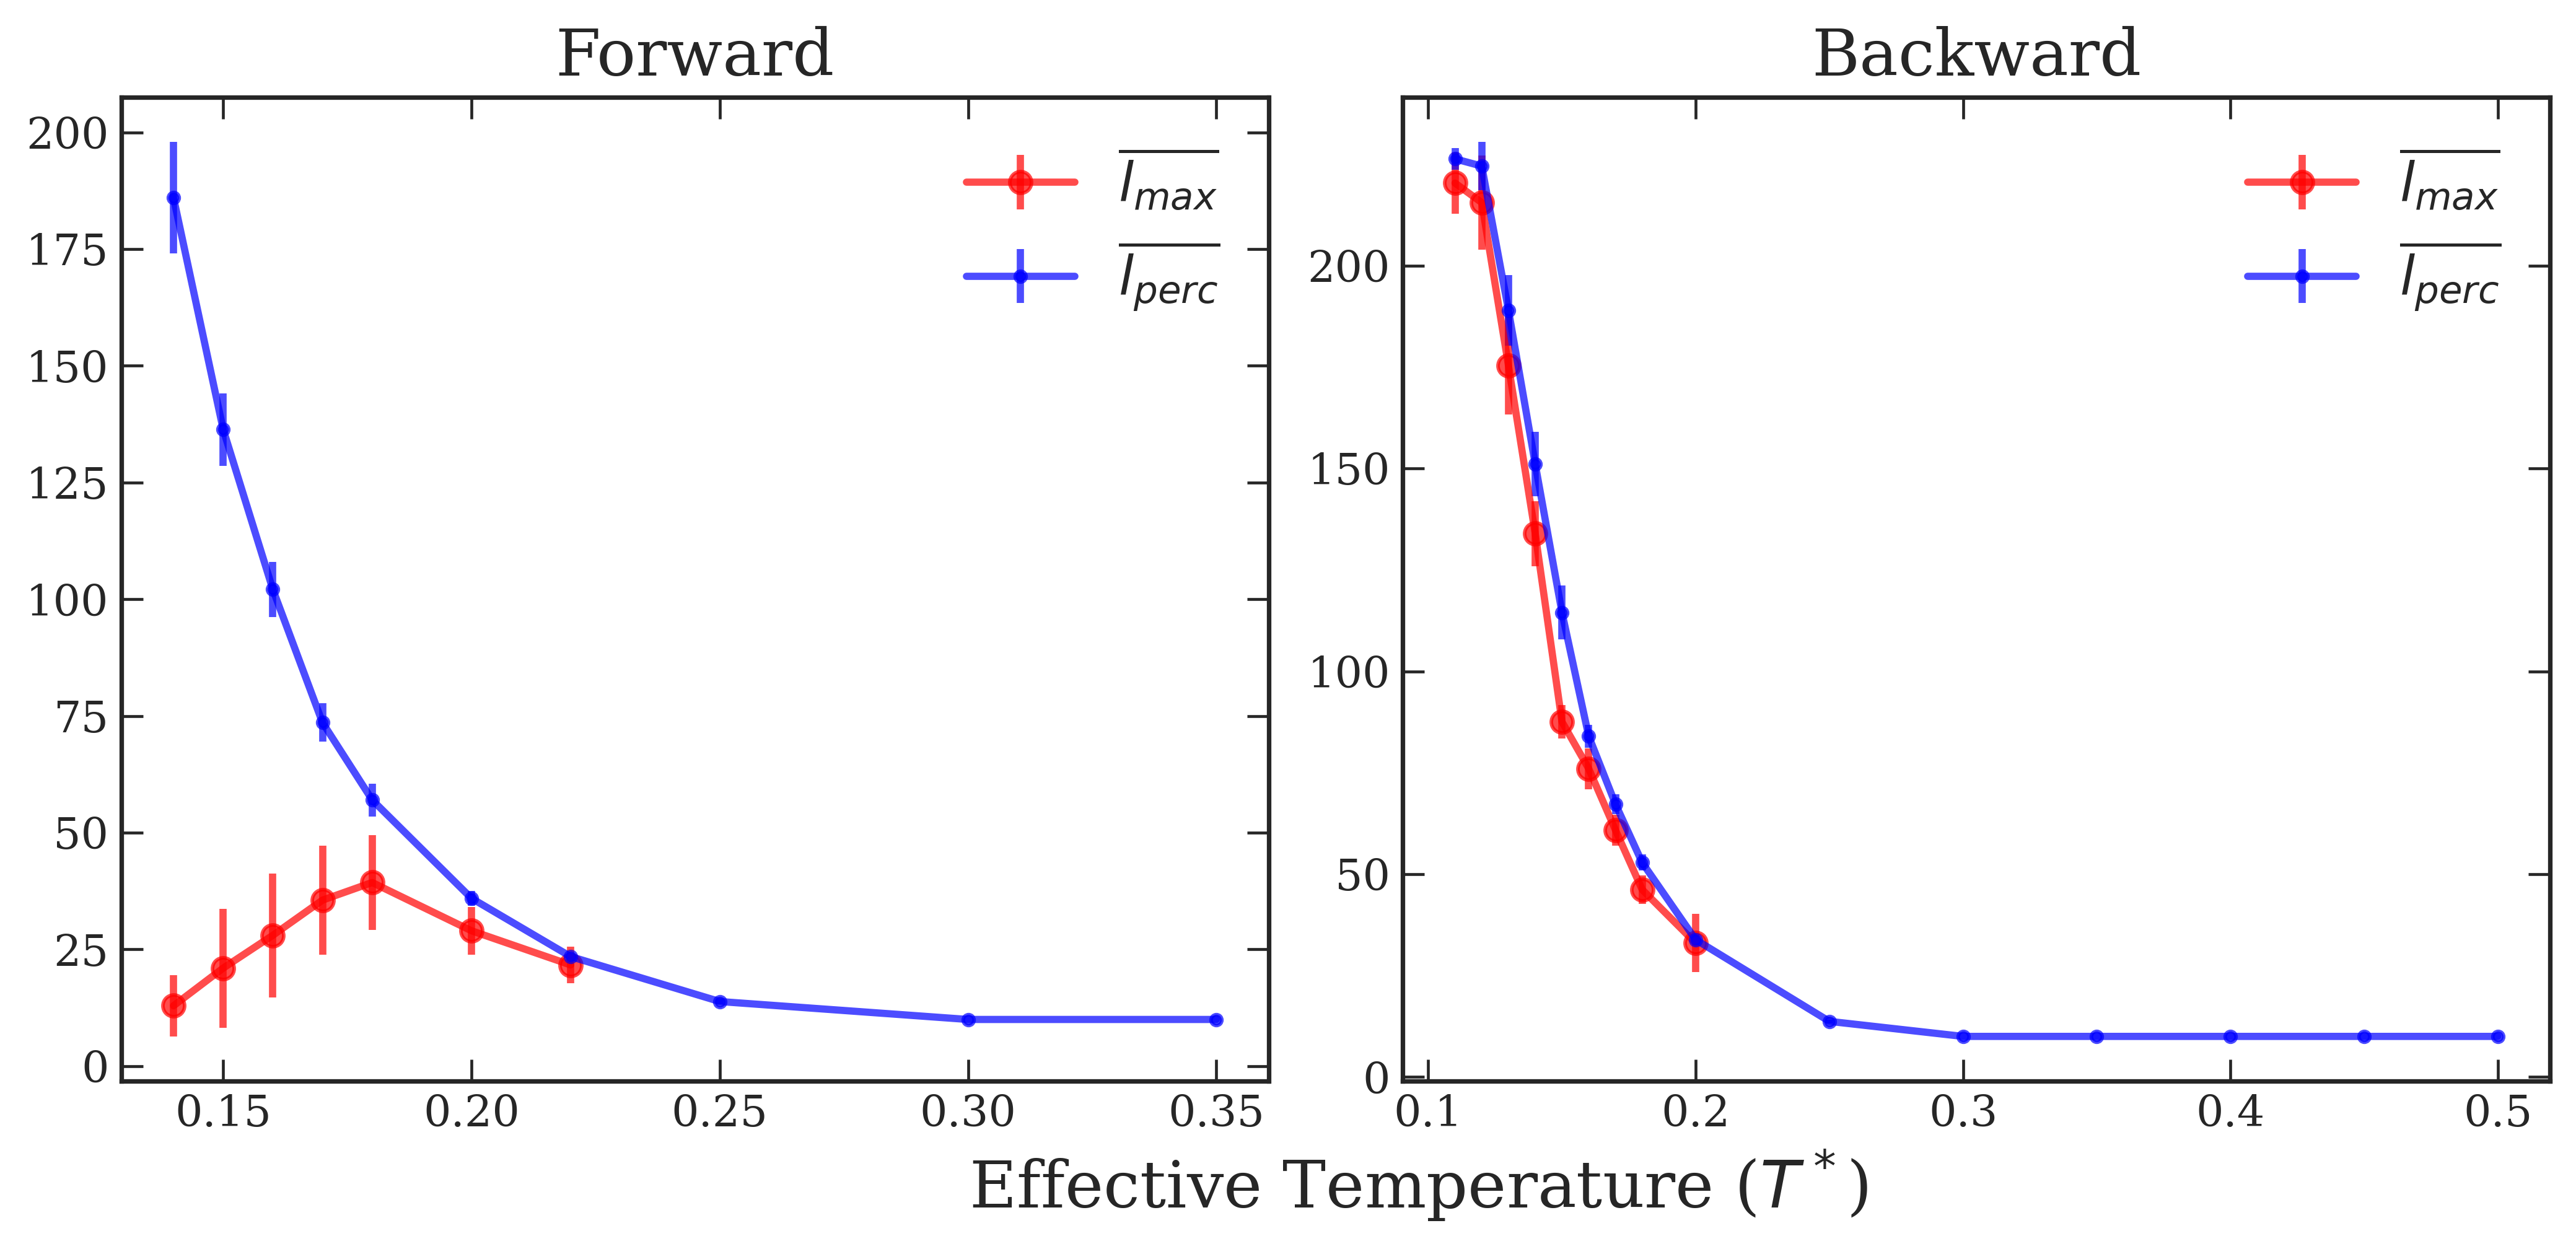

In [199]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))


ax[0].errorbar(act_fwd, lmax_av_fwd[:,0], yerr=lmax_av_fwd[:,1], alpha=.7,fmt='ro-', label=r'$\overline{l_{max}}$')
ax[0].errorbar(act_fwd, lperc_av_fwd[:,0], yerr=lperc_av_fwd[:,1], alpha=.7, fmt='b.-', label=r'$\overline{l_{perc}}$')
ax[0].title.set_text('Forward')
ax[0].legend()  

ax[1].errorbar(act_bck, lmax_av_bck[:,0], yerr=lmax_av_bck[:,1], alpha=.7, fmt='ro-', label=r'$\overline{l_{max}}$')
ax[1].errorbar(act_bck, lperc_av_bck[:,0], yerr=lperc_av_bck[:,1], alpha=.7, fmt='b.-', label=r'$\overline{l_{perc}}$')
ax[1].title.set_text('Backward')
ax[1].legend()

fig.supxlabel(r'Effective Temperature ($T^*$)', x=0.55, y=0.05)

if save_figs:
    fig.savefig(os.path.join(fig_path, 'lmax_lperc.png'), bbox_inches = 'tight', dpi = 420)